# Running a statistical trial for a machine learning regression model

In a previous [post](http://www.erikdrysdale.com/threshold_and_power) I discussed how to calibrate a machine learning (ML) model for a binary classification task in the context of a statistical trial. The classical ML pipeline is to train and tune a model on a training and validation set, and then make predictions (only once) on a test set to get an "unbiased" estimate of a performance metric(s) that this model will have.[[^1]] A statistical trial represents a further iteration on the ML pipeline: collecting data prospectively to "confirm" that the model works as well as you expect.

For binary classifiers there are two statistical goals in preparing for a prospective trial: 1) using the test set to pick a threshold that will give the algorithm some pre-specified performance bound, and 2) determining a sample size necessary to reject a null hypothesis of a worst-case performance on the prospective dataset. The first task was made easy by the fact that the desired performance level (e.g. sensitivity of 90%) could be chosen *a priori*, and the threshold would adjust *ex post* to match this expectation. In other words: the null hypothesis was known in advance, but the threshold was a random variable. 

The regression case is more complicated because the desired performance cannot be chosen in advance: the result is what it is. It is possible to pre-specify a null hypothesis (e.g. R-squared greater than 10%), and only run prospective trials for algorithms that rejected this null, such an approach would create a statistical significance [filter](http://www.erikdrysdale.com/winners_curse). Such a process would guarantee that, conditional on success (i.e. rejection of null), the expected test set performance will be biased upwards. Such a bias will lead to poor generalization and an underestimate of the prospective sample size that will be needed.

Instead I recommend that a two-stage testing strategy is used, where the test set establishes a bound on the null hypothesis, and the prospective trial aims to reject the upper bound on some error statistic. This approach has several advantages:

1. Model performance will be unbiased
2. Classical statistical techniques can be used to obtain valid inference
3. The upper bound can be chosen with respect to power considerations or the application use case, or both

The rest of the post is structured as follows: section (1) provides the statistical framework for a two-stage testing strategy for estimating the mean of a Gaussian, section (2) shows how two common regression performance metrics can be used and approximated by a Gaussian distribution, and section (3) provides an example pipeline of how this framework can be used.

## (1) Two-stage testing approach

Imagine you will have access to two independent datasets, and your goal is to establish an upper-bound on the "true" mean of a Gaussian distribution. In the first stage, a sample is drawn, and the distribution of the sample mean is used to estimate the null hypothesis. In the second stage, a new sample is drawn, and the null from stage 1 is used to calculate a test statistic and a p-value is calculated. Assume the data is IID and comes from a normal with a known variance: $X_i \sim N(\mu, \sigma^2)$.

$$
\begin{align*}
&\text{Step 1: Establish null} \\
\hat{\mu}_0 &= \hat\mu_1 + k \sqrt{\sigma / n_1} \\
H_0&: \mu_0 \geq \hat{\mu}_0 \\
H_A&: \mu_0 < \hat{\mu}_0 \\
&\text{Step 2: Test on second sample} \\
s_2 &= \frac{\hat\mu_2 - \hat\mu_0}{\sqrt{\sigma^2 / n_2}} \\
\text{Reject }H_0&: s_2 < \Phi_{s_2}^{-1}(\alpha) = t_\alpha
\end{align*}
$$

In the first stage, the null is estimated as the point estimate of the mean plus $k$ standard deviations above it. The choice of $k$ determines how much slack we want to build into the testing in the second stage. The larger the $k$, the easier it is the reject the null, although the less information we have about the mean. Consider the distribution of $s_2$, which is the test statistic in the second stage of the procedure:

$$
\begin{align*}
s_2&= \frac{\hat\mu_2-[\hat\mu_1+k\sqrt{\sigma^2/n_1}]}{\sigma^2/n_2} \\
&= z_2 - \sqrt{n_2/n_1}(z_1 + k) \\
z_i &= \frac{\hat\mu_i - \mu}{\sqrt{\sigma^2 / n_i}}
\end{align*}
$$

The unconditional distribution of the statistic can be seen to have a normal distribution:

$$
\begin{align*}
s_2&\sim N(-\sqrt{n_2/n_1}\cdot k, 1+n_2/n_1)
\end{align*}
$$

For a given $n_2$, as $n_1 \to \infty$, then the probability of rejecting the null, $P(s_2 < t_\alpha)$ approaches $\alpha$ since $s_2 \to N(0,1)$. For a given $n_1$, as $n_2 \to \infty$, then the probability of rejecting the null approaches $\Phi(k)$. However, in order to calculate the type-I and type-II errors of a testing procedure we need to know the distribution of $s_2$ conditional on the status of the null. Such as distribution is more complex:

$$
\begin{align}
s_2 | \{\text{$H_0$ is false}\} &\sim \frac{\hat\mu_2-\hat\mu_0}{\sqrt{\sigma^2/n_2}} \hspace{1mm} \Big|\hspace{1mm} \hat\mu_0 > \mu \nonumber \\
&\sim z_2 - r\cdot z_1^k | z_1^k > 0 \label{eq:dist_cond} \\
z_1^k &= z_1 + k, \hspace{3mm} r = \sqrt{n_2/n_1} \nonumber
\end{align}
$$

The conditional test statistic in \eqref{eq:dist_cond} is equivalent to a weighted sum of a standard normal and a truncated normal distribution. How can we characterize this distribution? The first step is to define a bivariate normal distribution as a function of $z_2\sim N(0,1)$ and $z_1^k~\sim(k,1)$.

$$
\begin{align}
X&= z_2 - r\cdot Y \nonumber \\ 
Y&= z_1^k \nonumber\\
\begin{pmatrix} X \\ Y \end{pmatrix} &\sim \text{MVN}\Bigg[ \begin{pmatrix} -rk \\ k \end{pmatrix}, \begin{pmatrix} 1+r^2 & -r \\ -r & 1 \end{pmatrix} \Bigg] \label{eq:dist_MVN} \\
\rho &= \frac{-r}{\sqrt{1+r^2}} \nonumber
\end{align}
$$

How does this help us? Luckily the distribution of a truncated bivariate normal distribution for one of the variables has been [characterized](https://link.springer.com/article/10.1007/BF02294652) already by *Arnold et. al*. After working out some of the math, the density function of \eqref{eq:dist_MVN} conditional on $Y > 0$ or $Y<0$ can be written as follows:

$$
\begin{align*}
f_X(x) &= \frac{1}{\Phi(s\cdot k)} \cdot \frac{1}{\sqrt{1+r^2}} \cdot \phi\Bigg(\frac{x+rk}{\sqrt{1+r^2}} \Bigg) \cdot \Phi\Bigg(s\cdot \Bigg[ -r\cdot \frac{x+rk}{\sqrt{1+r^2}} + \sqrt{1+r^2}\cdot  k \Bigg] \Bigg) \\
s &= \begin{cases}
+1 &\text{ if } \text{$H_0$ is false, } \hspace{2mm} (Y>0) \\
-1 &\text{ if } \text{$H_0$ is true, }  \hspace{2mm} (Y<0)
\end{cases} \\
f_W(w) &= \frac{1}{\Phi(k)} \cdot \frac{1}{\sigma_W} \cdot \phi(w) \cdot  \Phi(a + b\cdot w), \hspace{3mm} w=\frac{x+rk}{\sqrt{1+r^2}}
\end{align*}
$$

Next, we can use the result from Owen's classic [paper](https://www.tandfonline.com/doi/abs/10.1080/03610918008812164) which shows that we can [use](https://mathoverflow.net/questions/283928/closed-form-solution-for-an-integral-involving-the-p-d-f-and-c-d-f-of-a-n0-1) the CDF of a bivariate normal to calculate the CDF of $W$:

$$
\begin{align*}
F_W(w) &= \frac{1}{\Phi(s\cdot k)} \int_{-\infty}^w \frac{1}{\sigma_W} \cdot \phi(u) \cdot  \Phi(a + b\cdot u) du \\
&= \frac{1}{\Phi(s\cdot k)}  \text{BVN}\Big( X_1 \leq \frac{a}{\sqrt{1+b^2}}, X_2 \leq w, \rho=-b/\sqrt{1+b^2} \Big) \\
F_X(x) &= F_W\big((x+rk) / \sqrt{1+r^2}\big) \label{eq:cdf_X}
\end{align*}
$$

The first code block below shows how to calculate the CDF of \eqref{eq:dist_cond} using \eqref{eq:cdf_X}. Simulations are run showing that this CDF accurately captures the conditional distribution of the test statistic of interest. 

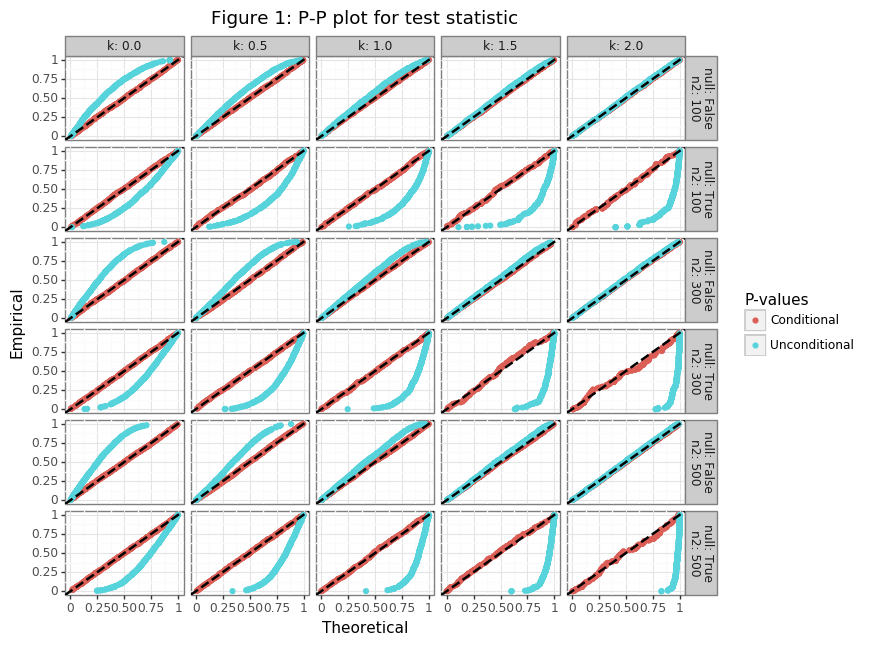

<ggplot: (8728843981305)>

In [1]:
import numpy as np
from scipy.stats import norm
from scipy.stats import multivariate_normal as MVN
import pandas as pd
import plotnine
from plotnine import *
from scipy.optimize import minimize_scalar

class cond_dist():
    def __init__(self, k, n1, n2, null=False):
        self.s = +1
        if null is True:
            self.s = -1
        self.k, self.n1, self.n2 = k, n1, n2
        self.r = np.sqrt(n2 / n1)
    
    def cdf_w(self, w):
        a = np.sqrt(1+self.r**2) * self.k * self.s
        b = -self.r * self.s
        rho = -b/np.sqrt(1+b**2)
        Sigma = np.array([[1,rho],[rho,1]])
        dist_MVN = MVN(mean=np.repeat(0,2),cov=Sigma)
        x1 = a / np.sqrt(1+b**2)
        if isinstance(w, float):
            X = [x1, w]
        else:
            X = np.c_[np.repeat(x1,len(w)), w]
        pval = dist_MVN.cdf(X)
        return pval
    
    def cdf_x(self, x):
        const = 1 / norm.cdf(self.s * self.k)
        w = (x + self.r * self.k) / np.sqrt(1+self.r**2)
        pval = self.cdf_w(w) * const
        return pval
    
    def quantile(self, p):
        res = minimize_scalar(fun=lambda x: (self.cdf_x(x)-p)**2, method='brent').x
        return res
    
seed = 1234
n1 = 100
sig2 = 2
mu = 3
nsim = 5000

n2_seq = [100, 300, 500]
k_seq = list(np.arange(0,2.5,0.5))

np.random.seed(seed)
holder = []
for k in k_seq:
    for n2 in n2_seq:
        c = k * np.sqrt(sig2/n1)
        # Draw samples for two-stages
        x1 = mu + np.sqrt(sig2)*np.random.randn(n1, nsim)
        x2 = mu + np.sqrt(sig2)*np.random.randn(n2, nsim)
        xbar1, xbar2 = x1.mean(0), x2.mean(0)
        null_mu = xbar1 + c
        s2 = (xbar2 - null_mu)/np.sqrt(sig2/n2)
        # Calculate the p-values
        pval_h0false = cond_dist(k=k, n1=n1, n2=n2, null=False).cdf_x(s2)
        pval_h0true = cond_dist(k=k, n1=n1, n2=n2, null=True).cdf_x(s2)
        pval_uncond = norm(loc=-np.sqrt(n2/n1)*k,scale=np.sqrt(1+n2/n1)).cdf(s2)
        tmp = pd.DataFrame({'s2':s2,'mu0':null_mu,'n2':n2,'k':k,
                            'h0_false':pval_h0false, 'h0_true':pval_h0true,'pval_uncond':pval_uncond})
        holder.append(tmp)
        del tmp
df_res = pd.concat(holder).assign(null=lambda x: np.where(x.mu0 > mu, False, True))
cn_gg = ['null','n2','k']
df_res = df_res.sort_values(cn_gg+['s2']).reset_index(None,True)
df_res = df_res.assign(idx=df_res.groupby(cn_gg).cumcount())
df_res.idx = df_res.groupby(cn_gg).apply(lambda x: x.idx/x.idx.max()).values
# Compare the conditional distribution
df_res = df_res.assign(pval_cond=lambda x: np.where(x.null==False,x.h0_false,x.h0_true))
df_res_long = df_res.melt(cn_gg+['idx'],['pval_cond','pval_uncond'],'tt')

# Make a pp-plot
tmp = df_res_long.groupby(cn_gg+['tt']).sample(n=250, random_state=seed,replace=True)
plotnine.options.figure_size = (8, 7)
gg_pp = (ggplot(tmp, aes(x='value',y='idx',color='tt')) + theme_bw() + 
         geom_point() + labs(x='Theoretical',y='Empirical') + 
         ggtitle('Figure 1: P-P plot for test statistic') + 
         facet_grid('n2+null~k',labeller=label_both) + 
         scale_color_discrete(name='P-values',labels=['Conditional','Unconditional']) + 
         geom_abline(slope=1,intercept=0,linetype='--',color='black',size=1))
gg_pp

Figure 1 shows that the CDF for the conditional distribution in \eqref{eq:cdf_X} accurately captures the distribution of the test statistic when the null is both false and true. When the null is false ($z_1^k > 0)$, for larger values of $k$, the unconditonal distribution of $s_2$ is a close approximation. This result makes sense since when the null hypothesis is set many standard deviations above the point estimate, the null will be false for almost all realizations so the conditioning event excludes very few samples. 

In classical statistics we pick a critical value to reject the null such that when the null is true, then rejection event happens at most $\alpha$ percent of the time. We can use \eqref{eq:cdf_X} to find the $\alpha-$quantile of the distribution when the null is true so that we reject it at most $a$-percent of the time:

$$
\begin{align*}
F^{-1}_W(\alpha) &= \sup_w: \{ F_W(w)\leq \alpha \}
\end{align*}
$$

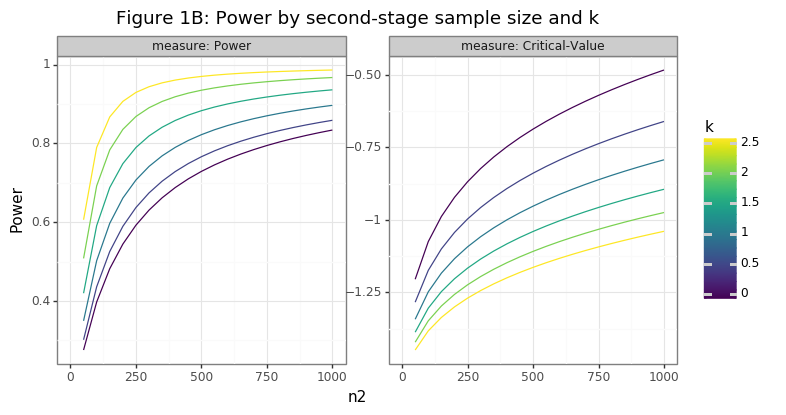

<ggplot: (-9223371875242511664)>

In [254]:
np.random.seed(seed)
# Calculate power for a range of n2's/k's
alpha = 0.05
n2_seq = np.arange(50,1001, 50)
k_seq = np.arange(0.0, 2.51, 0.50)
holder = []
for k in k_seq:
    for n2 in n2_seq:
        dd_true = cond_dist(k=k, n1=n1, n2=n2, null=True)
        dd_false = cond_dist(k=k, n1=n1, n2=n2, null=False)
        crit = dd_true.quantile(alpha)
        power_theory = dd_false.cdf_x(crit)
        # --- simulation --- #
        c = k * np.sqrt(sig2/n1)
        # Draw samples for two-stages
        x1 = mu + np.sqrt(sig2)*np.random.randn(n1, nsim)
        x2 = mu + np.sqrt(sig2)*np.random.randn(n2, nsim)
        xbar1, xbar2 = x1.mean(0), x2.mean(0)
        null_mu = xbar1 + c
        s2 = (xbar2 - null_mu)/np.sqrt(sig2/n2)
        power_emp = np.mean(s2[null_mu > mu] < crit)
        type1_emp = np.mean(s2[null_mu < mu] < crit)
        # ------------------ #
        tmp = pd.Series({'k':k,'n2':n2,'Critical-Value':crit,'Power':power_theory,
                         'emp_power':power_emp, 'emp_type1':type1_emp})
        holder.append(tmp)
        del tmp
df_power = pd.concat(holder,1).T
df_power_long = df_power.melt(['k','n2'],['Critical-Value','Power'],'measure')
df_power_long.measure = pd.Categorical(df_power_long.measure,['Power','Critical-Value'])

plotnine.options.figure_size = (8, 4)
gg_power = (ggplot(df_power_long,aes(x='n2',y='value',color='k',group='k')) + theme_bw() + 
            geom_line() + labs(x='n2',y='Power') + 
            facet_wrap('~measure',labeller=label_both,scales='free_y') + 
            ggtitle('Figure 1B: Power by second-stage sample size and k') + 
            theme(subplots_adjust={'wspace': 0.15}) + 
            scale_x_continuous(limits=[0,1001]))
gg_power

Figure 1B reveals that as the second-stage sample size or the value of $k$ grows, the power of the test increases. Higher values of $k$ ensures that the expected value between $\hat\mu_2 - \hat\mu_0$ becomes increasingly negative, increasing the probability of rejection. A higher sample size ($n_2$) decreases the variation of $\hat\mu_2$, so that the same difference is more consistently negative, once again increasing the probability of rejection. 

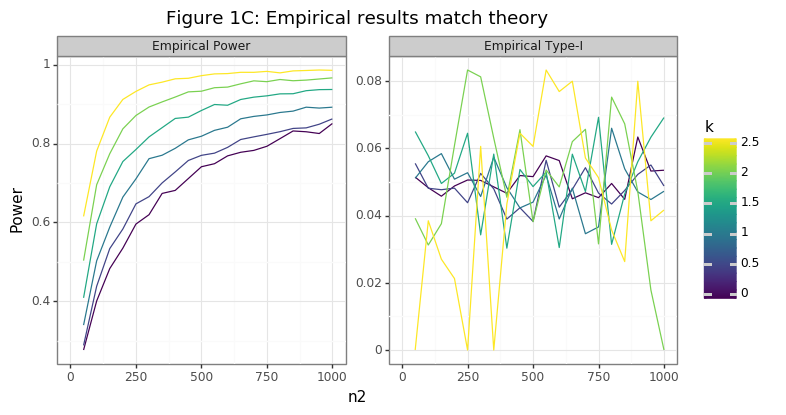

<ggplot: (-9223371875152263268)>

In [256]:
df_emp_long = df_power.melt(['k','n2'],['emp_power','emp_type1'],'tt')
df_emp_long.tt = df_emp_long.tt.map({'emp_power':'Empirical Power','emp_type1':'Empirical Type-I'})
plotnine.options.figure_size = (8, 4)
gg_emp = (ggplot(df_emp_long,aes(x='n2',y='value',color='k',group='k')) + theme_bw() + 
            geom_line() + labs(x='n2',y='Power') + facet_wrap('~tt',scales='free_y') + 
            ggtitle('Figure 1C: Empirical results match theory') + 
            theme(subplots_adjust={'wspace': 0.15}) + 
            scale_x_continuous(limits=[0,1001]))
gg_emp

Figure 1C shows that the empirical power curves line up with the theoretical expectation, and that the type-I error rates average to the expected level: 5%. Note that the empirical type-I error rates are not exactly 5% by random chance alone. For a large enough simulation sample they will converge to the 5% line.

## (2) Regression statistic inference example

This section will show how to apply the principle of two-stage testing to two common regression performance metrics: mean absolute error (MAE) and mean square error (MSE). In addition to being common metrics, these statistics also have known distributional properties when a linear regression model is used with Gaussian data. Hence, the statistical simulations can be benchmarked against a ground truth. Formally we are interested in the risk of the MAE/MSE loss functions:

$$
\begin{align*}
R_{MAE}(\theta) = E_{y\sim g(x)}[\text{MAE}(y,f_\theta(x)] \\
R_{MSE}(\theta) = E_{y\sim g(x)}[\text{MSE}(y,f_\theta(x)]
\end{align*}
$$

Where $y$ and $x$ are the response and the feature set, respectively, and $f_\theta(x)$ is a linear regression model indexed by its coefficient: $\theta$. Assume that the joint distribution comes from a Gaussian distribution:

$$
\begin{align*}
y &= x^T \theta^0 + u \\
u_i&\sim N(0,\sigma^2_u), \hspace{3mm} x \sim \text{MVN}(0,I) \\
e &= y - f_\theta(x) \\
&= x^T(\theta^0 - \theta) + u \\
&\sim N(0, \sigma^2_u + \| \theta^0 - \theta \|^2_2 )
\end{align*}
$$

The residuals of such a model also have a Gaussian distribution, with a variance equal to some irreducible error ($\sigma^2_u$) and the L2-norm of the coefficient error: $\sum_j (\theta_j^0 - \theta_j^2)$. The risk for the MSE or MAE can be easily calculated since $u$ has a known distribution:

$$
\begin{align}
R_{MSE}(\theta) &= E(u^2) = \sigma^2_u + \| \theta^0 - \theta \|^2_2 \label{eq:risk_mse} \\
R_{MAE}(\theta) &= E( |u| ) = \sqrt{\sigma^2_u + \| \theta^0 - \theta \|^2_2}\cdot\sqrt{2/\pi} \label{eq:risk_mae}
\end{align}
$$

Where the risk for the MAE comes from the [half-normal](https://en.wikipedia.org/wiki/Half-normal_distribution) distribution. The empirical estimate of the MAE and MSE is simply their sample average:

$$
\begin{align*}
\hat{\text{MSE}}(\theta) &= n^{-1} \sum_{i=1}^n [y_i - f_\theta(x_i)]^2 \\
\hat{\text{MAE}}(\theta) &= n^{-1} \sum_{i=1}^n |y_i - f_\theta(x_i)|
\end{align*}
$$

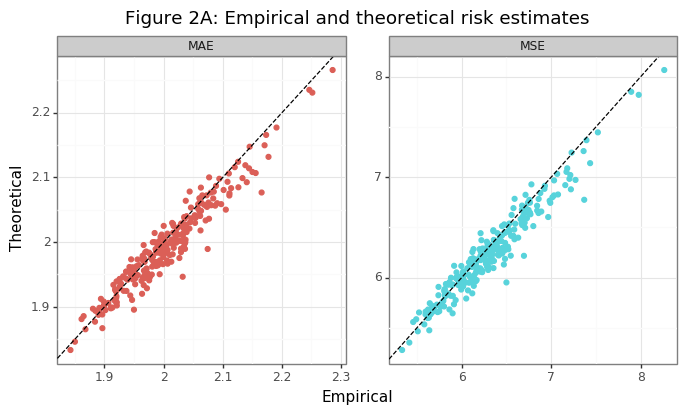

<ggplot: (8728843148961)>

In [337]:
from sklearn.linear_model import LinearRegression
from arch.bootstrap import IIDBootstrap
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE

def dgp_yX(n,p,t0=1,sig2=1,theta0=None):
    X = np.random.randn(n,p)
    if theta0 is None:
        theta0 = np.repeat(t0,p) * np.sign(np.random.rand(p)-0.5)
    eta = X.dot(theta0)
    error = np.sqrt(sig2)*np.random.randn(n)
    y = eta + error
    return y, X, theta0
    
np.random.seed(seed)
n, p, t0, sig2 = 100, 20, 0.5, t0**2*p
nsim = 250
holder = []
for ii in range(nsim):
    y, X, theta0 = dgp_yX(n, p, t0=t0, sig2=sig2)
    mdl = LinearRegression(fit_intercept=True).fit(y=y,X=X)
    l2_error = np.sum((theta0 - mdl.coef_)**2)
    ytest, Xtest, _ = dgp_yX(100*n, p, theta0=theta0, sig2=sig2)
    eta_test = mdl.predict(Xtest)
    # Calculate theoretical R(MSE), R(MAE)
    risk_mse, risk_mae = sig2 + l2_error, np.sqrt((sig2 + l2_error)*2/np.pi)
    hat_mse, hat_mae = MSE(ytest, eta_test), MAE(ytest, eta_test)
    tmp = pd.DataFrame({'risk_mse':risk_mse, 'hat_mse':hat_mse, 'risk_mae':risk_mae, 'hat_mae':hat_mae}, index=[ii])
    holder.append(tmp)
    del tmp
df_risk = pd.concat(holder).rename_axis('idx').reset_index().melt('idx',None,'tmp')
df_risk = df_risk.assign(tt=lambda x: x.tmp.str.split('_',2,True).iloc[:,0],
                         metric=lambda x: x.tmp.str.split('_',2,True).iloc[:,1]).drop(columns=['tmp'])
df_risk = df_risk.pivot_table('value',['idx','metric'],'tt').reset_index()

plotnine.options.figure_size = (8, 4)
gg_risk = (ggplot(df_risk,aes(x='hat',y='risk',color='metric')) + theme_bw() + 
           geom_point() + labs(x='Empirical',y='Theoretical') + 
           facet_wrap('~metric',labeller=labeller(metric={'mae':'MAE','mse':'MSE'}),scales='free') + 
           theme(subplots_adjust={'wspace': 0.15}) + guides(color=False) + 
           ggtitle('Figure 2A: Empirical and theoretical risk estimates') + 
           geom_abline(slope=1,intercept=0,linetype='--'))
gg_risk

Figure 2A shows that the empirical risk estimates are closely aligned with its theoretical counterparts. Once again, with a sufficient simulation sample size, these two lines would be identical. However, in practice, the variance of the residual and the "true" coefficient weight will never be known. Recall that in section 1, knowledge of the population standard deviation of the statistic ($\sigma$) was needed in order to calculate the test statistic ($s_2$). Because this quantity is unknown, bootstrap can be used to estimate the variance of the performance metric of interest (e.g. MSE & MAE). If $\hat\sigma_{BS}$ is the empirical standard deviation of the bootstrap, then we can estimate the population standard deviation by multiplying it by the number of sample $n_1$. 

In the simulation below, the accuracy of the bootstrap standard deviation will be compared to the true population standard deviation for the MSE. I am using the MSE rather than the MAE because the former can be characterized by a chi-square distribution:

$$
\begin{align*}
\frac{1}{\sqrt{\sigma^2 + \|\theta_0 - \theta \|_2^2}}\sum_{i=1}^n e_i^2 &\sim \chi^2_n  \\
Var(\chi^2) &= 2n \\
Var(\hat{\text{MSE}}(\theta)) &= \frac{\sigma^2_{MSE}}{n} = \frac{2[\sigma_u^2+\|\theta_0 - \theta \|_2^2]^2}{n}
\end{align*}
$$

Hence we can use the bootstrap variance to approximate the otherwise unknown quantity:

$$
\begin{align*}
\sigma^2_{MSE} &\approx n\cdot \hat\sigma^2_{BS}
\end{align*}
$$


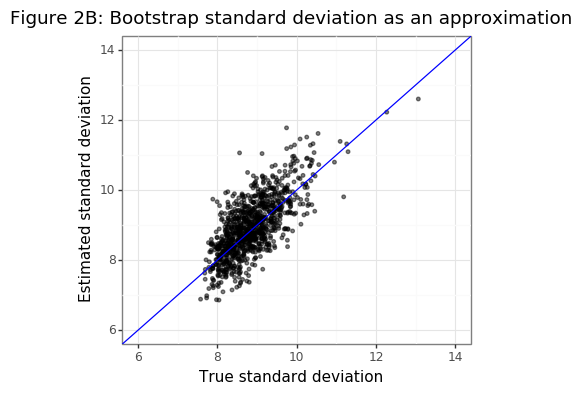

<ggplot: (8728838840465)>

In [395]:
n_bs = 1000
nsim = 1000
np.random.seed(seed)
ntrain = 100
ntest = 1000

holder = np.zeros([nsim,2])
for ii in range(nsim):
    y, X, theta0 = dgp_yX(ntrain, p, t0=t0, sig2=sig2)
    mdl = LinearRegression(fit_intercept=True).fit(y=y,X=X)
    l2_error = np.sum((theta0 - mdl.coef_)**2)
    sig2e = l2_error + sig2
    ytest, Xtest, _ = dgp_yX(ntest, p, theta0=theta0, sig2=sig2)
    eta_test = mdl.predict(Xtest)
    eta_boot = pd.Series(eta_test).sample(ntest*n_bs,replace=True)
    y_boot = ytest[eta_boot.index].reshape([ntest,n_bs])
    eta_boot = eta_boot.values.reshape([ntest,n_bs])
    res_boot = y_boot - eta_boot
    mse_boot = MSE(y_boot, eta_boot,multioutput='raw_values')
    sig2_mse = mse_boot.var()*len(ytest)
    sig2_gt = 2*sig2e**2
    holder[ii] = [sig2_mse, sig2_gt]
dat_sig2 = pd.DataFrame(holder,columns=['hat','gt'])
dat_sig2 = np.sqrt(dat_sig2)

xx, xm = np.ceil(dat_sig2.max().max()), np.floor(dat_sig2.min().min())
plotnine.options.figure_size = (4.5, 4)
gg_sig2 = (ggplot(dat_sig2, aes(x='gt',y='hat')) + theme_bw() + 
           geom_point(alpha=0.5,size=1) + 
           labs(y='Estimated standard deviation',x='True standard deviation') + 
           ggtitle('Figure 2B: Bootstrap standard deviation as an approximation') + 
           geom_abline(slope=1,intercept=0,color='blue') + 
           scale_x_continuous(limits=[xm, xx]) + scale_y_continuous(limits=[xm, xx]))
gg_sig2

Figure 2B shows that for a sufficiently large test set, we can estimate $\sigma^2_{MSE}$ so that we can simply divide it by $n$ to estimate the standard error for the MSE. Such a calculation will be essential for calculating a conservative null as well as normalizing the test statistic to have a standard normal distribution. At this point we are ready to run a simulation for the MSE and MAE using the procedure outlined in section (1). The pipeline is as follows:

1. Learn $f_\theta$ on a training dataset
2. Calculate MSE & MAE on test set
3. Bootstrap test set data to obtain the bootstrap variance: $\hat\sigma^2_{BS}$
4. Estimate the population variance of the MSE & MAE: $\sigma^2_{MSE} = n\cdot \hat\sigma^2_{BS}$

## (3) Applied example

Imagine you have been given an imaging dataset and you have trained a CNN to count the number of cells in the image. On a held-out test set you observe a MAE of 5. You are now asked to answer the following two questions:

1. How confident am I that this CNN will an MAE of no more than 10 cells on new datasets?
2. If we were to collect a new test set, how many samples would I need to reject the null that the MAE$\geq$10?

Even though the [point estimate](https://en.wikipedia.org/wiki/Point_estimation) of the MAE in this case is less than 10 (i.e. 5), this realization could simply be the case by random chance alone. To get a range of uncertainty around the MAE point estimate, a [bootstrap](http://www.erikdrysdale.com/bca_python/) approach can be used. Even if the empirical confidence intervals (CIs) do no contain 10, one still needs to figure out how many samples would be needed on a new test set to reject the null. In this post I propose a three-stage algorithm to running a prospective trial for a regression model for a given statistic of interest (SoI), e.g. MAE, or mean square error (MSE):

0. Train and tune a ML regression model on a training/validation set
1. Obtain the point estimate and an upper bound of the SoI on the test set
2. Determine the standard error of the SoI with the bootstrap to estimate the standard deviation of the SoI ($\sigma_{S}$ )
3. Use $\sigma_{S}$ and the point estimate to calculate the sample size needed for a prospective dataset

Throughout this post we will use both the MAE and MSE as possible statistics of interest: $\text{MAE}(y,f(x))=|y-f_\theta(x)|$, where $y$ is the continuous label, $f_\theta$ is the fixed regression model from step 0, and $x$ are the features. 

[^1]: This assumes that the test set is representative of the data generating process. If new data comes from a different distribution then any performance metrics evaluated on a test set will not be generalizable.